<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/2_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [16]:
import pandas as pd
import numpy as np

In [93]:
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")

In [94]:
df.head(5)

,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz
0,sys1,1.572807e+12,A,18.701342,24.334389,71.529175,12990.702148,13171.539062,502967.31250,359029.093750,38.720345,27.258642
1,sys2,1.572812e+12,A,10.630484,11.163696,64.186844,34157.523438,25964.236328,482210.59375,537779.562500,14.117196,20.712614
2,sys3,1.572812e+12,B,5.637269,7.230949,62.729401,11787.345703,5525.521484,394009.28125,172450.578125,33.425911,31.209654
3,sys4,1.572813e+12,A,3.380666,13.382729,56.605385,28032.042969,14931.455078,412009.06250,205794.531250,14.697840,13.782779
4,sys5,1.572817e+12,A,2.641213,17.485886,69.983536,22266.902344,7150.452148,658391.06250,225116.828125,29.568398,31.482992


In [ ]:
# check missing data
df.info()

In [ ]:
df.describe().T


In [ ]:
(df_stat['max']/df_stat['75%'])


## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

Columns

systemId - Device name

timestamp - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



In [ ]:
print(f" df.shape={df.shape},\n df.columns={df.columns}")
sysIDs = np.unique(df['systemId'])
print(f" sysIDs shape={sysIDs.shape},\n sysIDs={sysIDs}")
model_types = np.unique(df['model_type'])
print(f" model_types shape={model_types.shape}, model_types ={model_types}")

## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [95]:
# convert epoch in ms to datetime; 
# add sin/cos day, hour
import datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')
df.set_index(df.pop('datetime'), inplace=True)
df.head()


,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz
datetime,,,,,,,,,,,,
2019-11-03 18:45:00,sys1,1.572807e+12,A,18.701342,24.334389,71.529175,12990.702148,13171.539062,502967.31250,359029.093750,38.720345,27.258642
2019-11-03 20:10:00,sys2,1.572812e+12,A,10.630484,11.163696,64.186844,34157.523438,25964.236328,482210.59375,537779.562500,14.117196,20.712614
2019-11-03 20:20:00,sys3,1.572812e+12,B,5.637269,7.230949,62.729401,11787.345703,5525.521484,394009.28125,172450.578125,33.425911,31.209654
2019-11-03 20:35:00,sys4,1.572813e+12,A,3.380666,13.382729,56.605385,28032.042969,14931.455078,412009.06250,205794.531250,14.697840,13.782779
2019-11-03 21:35:00,sys5,1.572817e+12,A,2.641213,17.485886,69.983536,22266.902344,7150.452148,658391.06250,225116.828125,29.568398,31.482992


In [96]:
timestamp_s = df['timestamp']/1e3
hour = 60*60
day = 24*hour
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))

In [98]:
df.head()


,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz,Day sin,Day cos,Hour sin,Hour cos
datetime,,,,,,,,,,,,,,,,
2019-11-03 18:45:00,sys1,1.572807e+12,A,18.701342,24.334389,71.529175,12990.702148,13171.539062,502967.31250,359029.093750,38.720345,27.258642,-0.980785,0.195090,-1.000000,-1.184347e-10
2019-11-03 20:10:00,sys2,1.572812e+12,A,10.630484,11.163696,64.186844,34157.523438,25964.236328,482210.59375,537779.562500,14.117196,20.712614,-0.843391,0.537300,0.866025,5.000000e-01
2019-11-03 20:20:00,sys3,1.572812e+12,B,5.637269,7.230949,62.729401,11787.345703,5525.521484,394009.28125,172450.578125,33.425911,31.209654,-0.819152,0.573576,0.866025,-5.000000e-01
2019-11-03 20:35:00,sys4,1.572813e+12,A,3.380666,13.382729,56.605385,28032.042969,14931.455078,412009.06250,205794.531250,14.697840,13.782779,-0.779884,0.625923,-0.500000,-8.660254e-01
2019-11-03 21:35:00,sys5,1.572817e+12,A,2.641213,17.485886,69.983536,22266.902344,7150.452148,658391.06250,225116.828125,29.568398,31.482992,-0.591310,0.806445,-0.500000,-8.660254e-01


In [99]:
# StandardScaler + LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder

# defiine columns_to_scale: exclude categorical columns
columns_to_scale = list(df.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(f'columns_to_scale={columns_to_scale}')

autoscaler = StandardScaler()
df[columns_to_scale] = autoscaler.fit_transform(df[columns_to_scale])

# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df['systemId'] = label_encoder1.fit_transform(df['systemId'])
label_encoder2 = LabelEncoder()
df['model_type'] = label_encoder2.fit_transform(df['model_type'])

columns_to_scale=['timestamp', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'Day sin', 'Day cos', 'Hour sin', 'Hour cos']


In [100]:
df.head()

,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz,Day sin,Day cos,Hour sin,Hour cos
datetime,,,,,,,,,,,,,,,,
2019-11-03 18:45:00,0,-1.264469,0,1.308119,-0.854634,0.141935,-0.767293,-0.112829,-0.547523,0.130990,0.177385,0.427118,-1.388449,0.279950,-1.412823,-0.000320
2019-11-03 20:10:00,11,-1.257374,0,0.250507,-1.649555,-0.492133,0.318781,1.198901,-0.578615,0.735282,-1.004656,-0.164522,-1.194323,0.764357,1.227363,0.706460
2019-11-03 20:20:00,20,-1.256539,1,-0.403808,-1.886917,-0.617995,-0.829038,-0.896832,-0.710731,-0.499765,-0.076982,0.784216,-1.160074,0.815708,1.227363,-0.707100
2019-11-03 20:35:00,21,-1.255287,0,-0.699515,-1.515625,-1.146851,0.004482,0.067628,-0.683769,-0.387041,-0.976759,-0.790852,-1.104593,0.889806,-0.705388,-1.224498
2019-11-03 21:35:00,22,-1.250278,0,-0.796414,-1.267977,0.008457,-0.291329,-0.730216,-0.314714,-0.321719,-0.262314,0.808921,-0.838152,1.145339,-0.705388,-1.224498


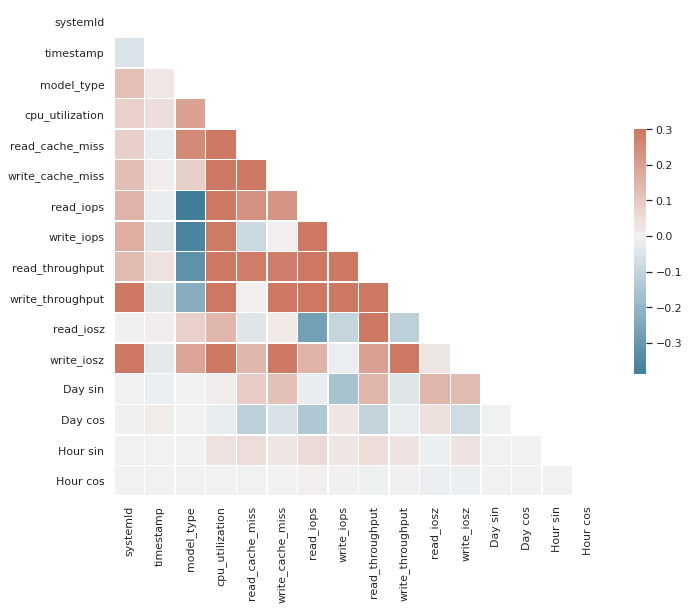

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)


In [69]:
# normalization
# defiine columns_to_scale
df_plot = df.copy()

columns_to_scale = list(df_plot.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(columns_to_scale)


['timestamp', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz', 'Day sin', 'Day cos', 'Hour sin', 'Hour cos']


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
autoscaler = StandardScaler()
df_plot[columns_to_scale] = autoscaler.fit_transform(df_plot[columns_to_scale])


In [ ]:
df_plot.head()

In [72]:
from sklearn.preprocessing import LabelEncoder
# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df_plot['systemId'] = label_encoder1.fit_transform(df_plot['systemId'])
label_encoder2 = LabelEncoder()
df_plot['model_type'] = label_encoder2.fit_transform(df_plot['model_type'])

In [76]:
df_plot.head()
columns_to_scale = df_plot.columns
print(columns_to_scale)

Index(['systemId', 'timestamp', 'model_type', 'cpu_utilization',
       'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz',
       'Day sin', 'Day cos', 'Hour sin', 'Hour cos'],
      dtype='object')


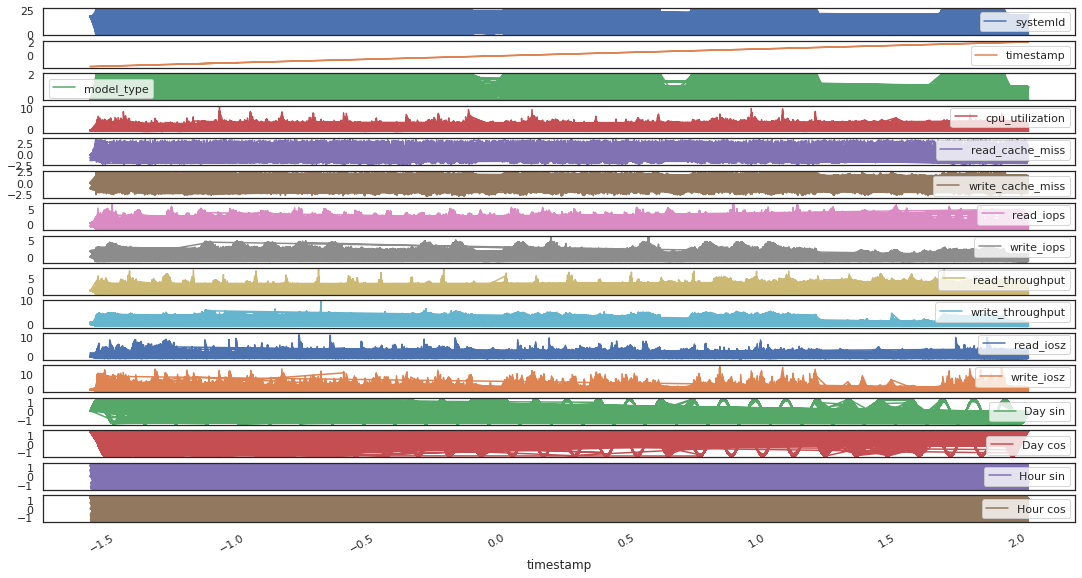

In [77]:
plot_features = df_plot[columns_to_scale]
plot_features.index = df_plot['timestamp']
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


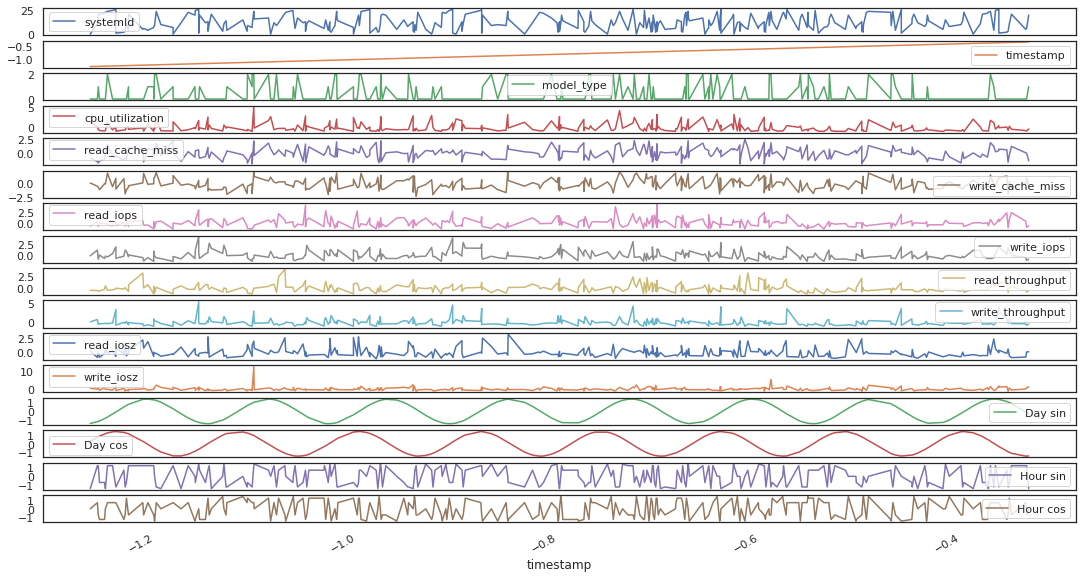

In [79]:
samples = int(24*60/5)
plot_features = df_plot[columns_to_scale][:samples]
plot_features.index = df_plot['timestamp'][:samples]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# sample period is 5 min
sample_period = 5
plot_len = int(24*60/5)
plot_features = df[columns_to_scale][:plot_len]
plot_features.index = df1_sysId['timestamp'][:plot_len]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

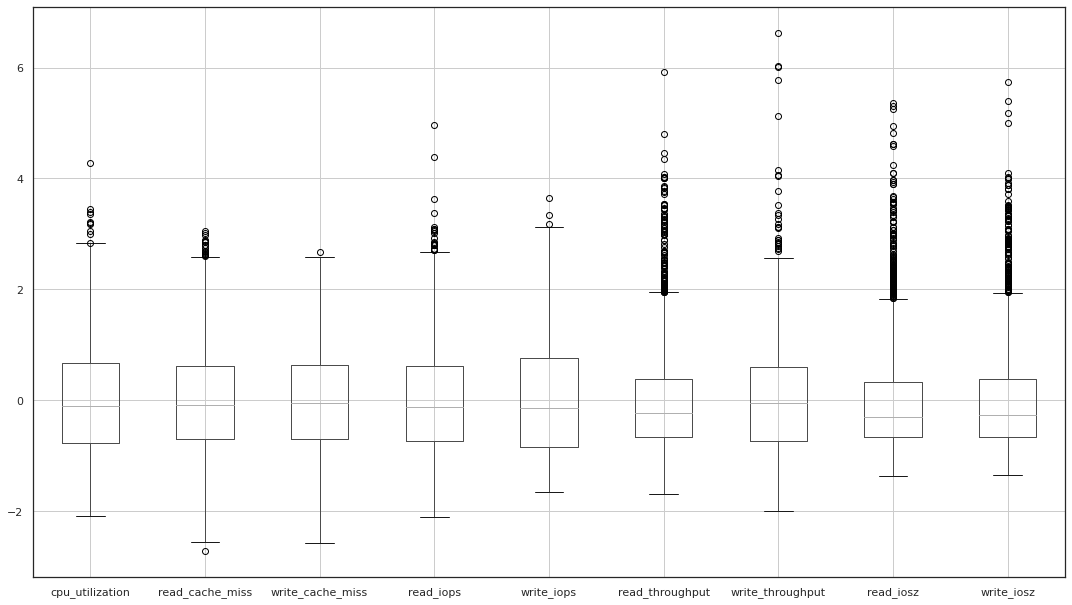

In [ ]:

boxplot = df1_sysId.boxplot(column=columns_to_scale)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


Text(0.5, 1.0, 'Time of day signal')

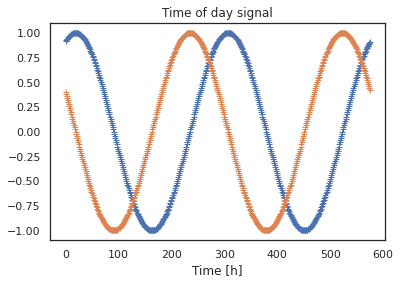

In [ ]:
sample_period = 5
plot_len = int(2*24*60/5) # plot 2 day

plt.plot(np.array(df1_sysId['Day sin'])[:plot_len], '+')
plt.plot(np.array(df1_sysId['Day cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of Year signal')

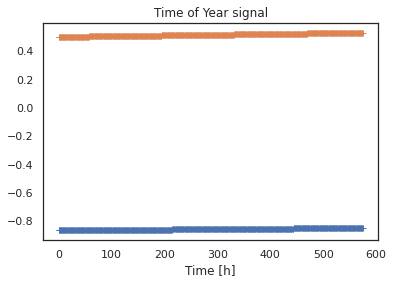

In [ ]:
plt.plot(np.array(df1_sysId['Year sin'])[:plot_len], '+')
plt.plot(np.array(df1_sysId['Year cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

In [ ]:
df1_sysId.describe().T


,count,mean,std,min,25%,50%,75%,max
cpu_utilization,1952.0,-3.890331e-17,1.000256,-2.088536,-0.770918,-0.104653,0.671069,4.275441
read_cache_miss,1952.0,-1.311423e-16,1.000256,-2.726930,-0.698705,-0.094416,0.621408,3.051646
write_cache_miss,1952.0,1.573195e-16,1.000256,-2.577265,-0.696552,-0.044753,0.630073,2.665782
read_iops,1952.0,1.899664e-17,1.000256,-2.100068,-0.734433,-0.116606,0.626800,4.958413
write_iops,1952.0,1.162549e-16,1.000256,-1.653998,-0.850587,-0.138065,0.757738,3.643233
read_throughput,1952.0,1.685241e-16,1.000256,-1.690705,-0.671588,-0.229665,0.376630,5.912620
write_throughput,1952.0,-2.814233e-16,1.000256,-2.001948,-0.737455,-0.050972,0.604645,6.631765
read_iosz,1952.0,-2.015692e-16,1.000256,-1.363266,-0.660542,-0.298023,0.337359,5.358109
write_iosz,1952.0,-2.207649e-16,1.000256,-1.355002,-0.670759,-0.263300,0.377392,5.734200
Day sin,1952.0,-1.991646e-02,0.707894,-1.000000,-0.722364,-0.043619,0.691513,1.000000


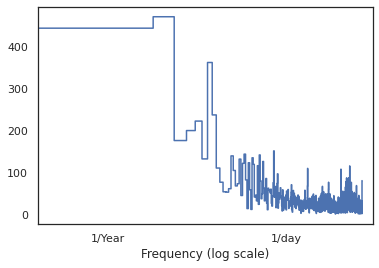

In [ ]:
# fft plot
import tensorflow as tf
fft = tf.signal.rfft(df1_sysId['cpu_utilization'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1_sysId['cpu_utilization'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [ ]:
cols_std =  ['read_iops', 'read_cache_miss']
cols_rolling_mean = ['write_throughput', 'write_iosz']
cols_exp_mvavg = ['write_cache_miss', 'write_iops']

group_by_systemId = df1.groupby("systemId") #, axis="columns"
group = group_by_systemId.get_group('sys1')
group = group[['timestamp', 'write_throughput', 'write_iosz']]

print(f'len ={len(group)}')
group.head(8)



len =1952


,timestamp,write_throughput,write_iosz
0,2019-11-03 18:45:00,359029.093750,27.258642
24,2019-11-04 11:10:00,391059.843750,33.317554
49,2019-11-05 06:30:00,644081.062500,27.810186
76,2019-11-05 22:55:00,588804.312500,22.281116
103,2019-11-06 14:25:00,593935.125000,18.569221
113,2019-11-06 19:15:00,539323.062500,24.459118
127,2019-11-07 08:50:00,206256.484375,19.043331
743,2019-11-05 10:45:00,377669.687500,20.309162


In [ ]:
group = group.sort_values(by='timestamp')
group.head(8)

,timestamp,write_throughput,write_iosz
39319,2019-11-01 04:25:00,643395.06250,44.144405
168399,2019-11-01 04:30:00,452817.37500,33.769337
19678,2019-11-01 04:35:00,354100.65625,26.051140
172625,2019-11-01 04:40:00,402049.09375,28.529280
171162,2019-11-01 04:45:00,375960.68750,28.852577
157734,2019-11-01 04:50:00,336585.21875,26.842281
155093,2019-11-01 04:55:00,519666.68750,37.744625
172252,2019-11-01 05:00:00,568910.81250,37.253868


In [ ]:
tmp = group.rolling(2).mean()
tmp.head(8)

,write_throughput,write_iosz,rmean_write_throughput,rmean_write_iosz
39319,NaN,NaN,NaN,NaN
168399,548106.218750,38.956871,NaN,NaN
19678,403459.015625,29.910238,475782.617188,34.433555
172625,378074.875000,27.290210,390766.945312,28.600224
171162,389004.890625,28.690928,383539.882812,27.990569
157734,356272.953125,27.847429,372638.921875,28.269179
155093,428125.953125,32.293453,392199.453125,30.070441
172252,544288.750000,37.499247,486207.351562,34.896350


In [ ]:
group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

,timestamp,write_throughput,write_iosz,rmean_write_throughput,rmean_write_iosz
39319,2019-11-01 04:25:00,643395.06250,44.144405,NaN,NaN
168399,2019-11-01 04:30:00,452817.37500,33.769337,548106.218750,38.956871
19678,2019-11-01 04:35:00,354100.65625,26.051140,403459.015625,29.910238
172625,2019-11-01 04:40:00,402049.09375,28.529280,378074.875000,27.290210
171162,2019-11-01 04:45:00,375960.68750,28.852577,389004.890625,28.690928
157734,2019-11-01 04:50:00,336585.21875,26.842281,356272.953125,27.847429
155093,2019-11-01 04:55:00,519666.68750,37.744625,428125.953125,32.293453
172252,2019-11-01 05:00:00,568910.81250,37.253868,544288.750000,37.499247


In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [ ]:
df.columns

Index(['systemId', 'timestamp', 'model_type', 'cpu_utilization',
       'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz',
       'Day sin', 'Day cos', 'Hour sin', 'Hour cos'],
      dtype='object')

In [ ]:
# note timestamp is converted to sin cos of day hour so not used here
df_X = df[['systemId', 'model_type']].copy()

print(f'df_X: {df_X.columns}')
print(f'df: {df.columns}')

print(f'y: {df_Y}')
print(df['cpu_utilization'])



In [ ]:
# one-hot-encoder of systemId and model_type
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X = df_X.values
X = X.astype(str)

print(f'X={X[:3, :]}')
print(f'Y={Y[:3]}')
print(f'X shape={X.shape}')
print(f'Y shape={Y.shape}')

X=[['sys1' 'A']
 ['sys2' 'A']
 ['sys3' 'B']]
Y=[18.70134163 10.63048363  5.63726854]
X shape=(175505, 2)
Y shape=(175505,)


In [ ]:
# encode string input values as integers
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
	feature = onehot_encoder.fit_transform(feature)
	print(f'i={i}, shape={feature.shape}')
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
  
print("X shape: : ", encoded_x.shape)

i=0, shape=(175505, 27)
i=1, shape=(175505, 3)
X shape: :  (175505, 30)


In [ ]:
df_X = df.copy()
features_added_X = ['timestamp', 'cpu_utilization', 'systemId', 'model_type']
for i in features_added_X:
  del df_X[i]


In [ ]:
print(df_X.columns)
print(df_X.shape)
print(encoded_x.shape)
df_X.head()


In [ ]:
# Now encoded_x  contains the (27 for systemId) + (3 for model) = 30 categorical columns 
# Here, concatenate X's non-categorical 12 columns df_X with encoded_x to get a total of 42 columns
X = np.concatenate((encoded_x, df_X.values), axis=1)
print("X shape: : ", X.shape)



X shape: :  (175505, 42)


In [ ]:
Y = df['cpu_utilization'].values
print("Y shape: : ", Y.shape)


Y shape: :  (175505,)


## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

In [ ]:
CV_FOLDS = 2
# Regression
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=2, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits = CV_FOLDS)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -10.58 (0.27) MSE


## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

## Q8. How do improve the accuracy of Random forest regressor

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?



In [ ]:
df.plot(subplots=True)